In [8]:
# import libraries
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    import texthero as hero
    from texthero import preprocessing

    from sklearn.preprocessing import LabelEncoder
    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import train_test_split
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.pipeline import Pipeline
    from sklearn.ensemble import RandomForestClassifier
    from imblearn.over_sampling import SMOTE

    from sklearn.linear_model import SGDClassifier
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier

    from sklearn.feature_selection import chi2, SelectKBest


    import warnings
except(ImportError):
    print(f'Import Error: {ImportError}')

# ignore warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# set seeds for reproducability
from numpy.random import seed
seed(500)

# global configurations
pd.set_option("display.max_colwidth", -1) # show larger text in pandas dataframe

In [2]:
# Text Cleaning and Pre-processing
def preprocess_text(features):
    # cleaning steps
    cleaning_pipeline = [
        preprocessing.fillna,
        preprocessing.lowercase,
        preprocessing.remove_whitespace,
        preprocessing.remove_punctuation,
        preprocessing.remove_urls,
        preprocessing.remove_brackets,
        preprocessing.remove_stopwords,
        preprocessing.remove_digits,
        preprocessing.remove_angle_brackets,
        preprocessing.remove_curly_brackets
    ]

    # apply pipeline to text
    clean_text = features.pipe(hero.clean, cleaning_pipeline)
    
    return clean_text

In [6]:
# read csv
df = pd.read_csv('processed_dataset_chi2.csv')
df.columns

target = df[['Category']]

df.drop(['Category'], axis=1, inplace=True)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))

##Experiments to find what the optimal columns##

In [45]:
# SGD, SVM, RF
columns = df.columns

accuracy_df = pd.DataFrame()

# uncomment out these 2 lines for bulk process
total_cols = len(columns)
for num_of_cols in range(total_cols):
# total_cols = 10 # try 1, 2, 3 ....10
# for num_of_cols in range(total_cols-1, total_cols):
    df['description'] = ''
    col_names = ''
    for i in range(num_of_cols+1):
        col_names = col_names + ' ' + columns[i]
        df['description'] = df['description'] + ' ' + df[columns[i]]
        
    clean_text = preprocess_text(df['description']) 

    clean_text = tfidf.fit_transform(clean_text).toarray()

    # split data
    x_train, x_test, y_train, y_test = train_test_split(clean_text, target, random_state=0, test_size=0.25, shuffle=True)

    # balance the data - optional
    oversample = SMOTE(random_state=0,n_jobs=-1,k_neighbors=5)
    x_train, y_train = oversample.fit_resample(x_train, y_train)
    
    # classification - SGD
    sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
    sgd.fit(x_train, y_train)
    y_pred = sgd.predict(x_test)
    sgd_accuracy = accuracy_score(y_test, y_pred)
    svc_accuracy = 0
    rf_accuracy = 0
    
#     #classification - SVM
#     svc = SVC(C=1.0, kernel = 'linear')
#     svc.fit(x_train, y_train)
#     y_pred = svc.predict(x_test)
#     svc_accuracy = accuracy_score(y_test, y_pred)

#     #classification - random forest
#     rf = RandomForestClassifier(random_state=44)
#     rf.fit(x_train, y_train)
#     y_pred = rf.predict(x_test)
#     rf_accuracy = accuracy_score(y_test, y_pred)

    new_row = {'col_names':col_names, 'sgd':sgd_accuracy, 'svm':svc_accuracy, 'rf': rf_accuracy}
    accuracy_df = accuracy_df.append(new_row, ignore_index=True)

    print(accuracy_df)

# save results to csv
accuracy_df.to_csv('accuracy_ML_chi2.csv', index=False)

 EventDescription
           col_names   rf       sgd  svm
0   EventDescription  0.0  0.701787  0.0
 EventDescription ActionTaken
                       col_names   rf       sgd  svm
0   EventDescription              0.0  0.701787  0.0
1   EventDescription ActionTaken  0.0  0.739372  0.0
 EventDescription ActionTaken IncidentCause
                                     col_names   rf       sgd  svm
0   EventDescription                            0.0  0.701787  0.0
1   EventDescription ActionTaken                0.0  0.739372  0.0
2   EventDescription ActionTaken IncidentCause  0.0  0.800370  0.0
 EventDescription ActionTaken IncidentCause IncidentConsequence
                                                         col_names   rf  \
0   EventDescription                                                0.0   
1   EventDescription ActionTaken                                    0.0   
2   EventDescription ActionTaken IncidentCause                      0.0   
3   EventDescription ActionTaken In

KeyboardInterrupt: 

                                                                                                                                                     col_names  \
0   EventDescription                                                                                                                                             
1   EventDescription ActionTaken                                                                                                                                 
2   EventDescription ActionTaken IncidentCause                                                                                                                   
3   EventDescription ActionTaken IncidentCause IncidentConsequence                                                                                               
4   EventDescription ActionTaken IncidentCause IncidentConsequence CauseCommunity                                                                                
5   EventDescription ActionT

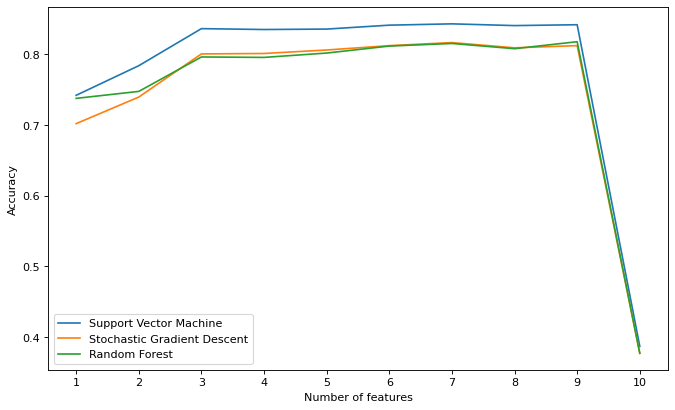

In [22]:
# retrieve from ds if object is no longer exist
accuracy_df = pd.read_csv('accuracy_ML_chi2.csv')
print(accuracy_df)

figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

x = range(1,len(accuracy_df)+1)
y1 = accuracy_df[['svm']]
plt.plot(x, y1, label = "Support Vector Machine")

y2 = accuracy_df[['sgd']]
plt.plot(x, y2, label = "Stochastic Gradient Descent")

y3 = accuracy_df[['rf']]
plt.plot(x, y3, label = "Random Forest")

plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x)

plt.show()

The top 3 relevant columns are:  EventDescription ActionTaken IncidentCause
The top 9 relevant columns are  EventDescription ActionTaken IncidentCause IncidentConsequence CauseCommunity FailedAssets CauseWorkP CauseTechnical CauseEnvironment

In [26]:
# selectK with 1000, 3000, 5000 features using 3 columns

df['description'] = df['EventDescription'] + ' ' + df['ActionTaken'] + ' ' + df['IncidentCause']

clean_text = preprocess_text(df['description']) 

clean_text = tfidf.fit_transform(clean_text).toarray()
print('Original number of features:', clean_text.shape[1])
      
# feature selection
num_of_selection = 0 # set to 0 to use all features
if num_of_selection > 0:
    ch2 = SelectKBest(chi2, k=num_of_selection)
    clean_text = ch2.fit_transform(clean_text, target)
print('Reduce number of features to:', clean_text.shape[1])

# split data
x_train, x_test, y_train, y_test = train_test_split(clean_text, target, random_state=0, test_size=0.25, shuffle=True)
   
# balance the data - optional
oversample = SMOTE(random_state=0,n_jobs=-1,k_neighbors=5)
x_train, y_train = oversample.fit_resample(x_train, y_train)
    
# classification - SGD
# sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
# sgd.fit(x_train, y_train)
# y_pred = sgd.predict(x_test)
# sgd_accuracy = accuracy_score(y_test, y_pred)
#print('SGD:', sgd_accuracy)
      
#classification - SVM
# svc = SVC(C=1.0, kernel = 'linear')
# svc.fit(x_train, y_train)
# y_pred = svc.predict(x_test)
# svc_accuracy = accuracy_score(y_test, y_pred)
# print('SVC:', svc_accuracy)

#classification - random forest
rf = RandomForestClassifier(random_state=44)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
rf_accuracy = accuracy_score(y_test, y_pred)
print('RF:', rf_accuracy)

Original number of features: 12099
Reduce number of features to: 12099
RF: 0.7960566851509551


SGD with 1000 features, accuracy is 78.19%
SGD with 3000 features, accuracy is 79.05%
SGD with 5000 features, accuracy is 79.48%
SGD with 12099 features (all), accuracy is 80.04%

SVC with 1000 features, accuracy is 80.9%
SVC with 3000 features, accuracy is 82.81%
SVC with 5000 features, accuracy is 83.86%
SVC with 12099 features, accuracy is 83.61%

RF with 1000 features, accuracy is 80.59%
RF with 3000 features, accuracy is 80.96%
RF with 5000 features, accuracy is 80.78%
RF with 12099 features, accuracy is 79.61%